In [1]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import os
from scipy.optimize import curve_fit, minimize
from matplotlib.colors import LogNorm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from GalPop import *
from tqdm.notebook import tqdm
cosmo = FlatLambdaCDM(H0=70, Om0=0.27)

In [2]:
# GRISM
griz_cat = np.loadtxt("./Data/HST_galfits_v1.2.cat", dtype=object)   # Load in the data
# Fix up the formatting for the spec data-file:
new_array = []
for idx in range(griz_cat.shape[1]):
    try:
        col = griz_cat[:,idx].astype(np.float32)
    except:
        col = griz_cat[:,idx]
    new_array.append(col)

griz = np.array(new_array, dtype=object)
griz = np.transpose(griz)

# Need blended flags from griz_cat
griz_rs_cat = np.loadtxt("./Data/HST_Hyp_zcat.v1.3.cat",  usecols=range(16), dtype=object)   # Load in the data
bfs = griz_rs_cat[:,5].astype(int)

print(f"Number of Grism redshifts: {griz.shape[0]}")


ra, dec = griz_rs_cat[:,1].astype(float), griz_rs_cat[:,2].astype(float)
zg, qf_gz = griz_rs_cat[:,13].astype(float), griz_rs_cat[:,15].astype(float)
mag = griz_rs_cat[:,3].astype(float) <= 25.0

Number of Grism redshifts: 12764


In [3]:
hst_ids = np.where((griz_rs_cat[:,13].astype(float) <= 2.70) & (griz_rs_cat[:,13].astype(float) >= 2.35)
         & (griz_rs_cat[:,15].astype(int) >=3) & (griz_rs_cat[:,3].astype(float) <= 25.0))[0]


hst_ids = np.where( (qf_gz>=3) & (zg>2.35) & (zg<2.70) & (ra>149.64) & (ra<150.48) & (dec>2.01) & (dec<2.57 ) )[0]


In [4]:
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")
sigs = [2.0, 2.5, 3.0, 4.0, 5.0]
sig_folders = [f"\sig{s}_peaks" for s in sigs]
pk_path = "HyperionPeaks/"
pk_sums = [f"peaks_sig{s}.dat" for s in sigs]

temp = GalPop(IDs=griz_rs_cat[:,4][hst_ids].astype(int),
               coords=np.c_[griz_rs_cat[:,1][hst_ids].astype(float),griz_rs_cat[:,2][hst_ids].astype(float), griz_rs_cat[:,13][hst_ids].astype(float)])
temp.assignPeaks(sigs, sig_cube, pk_path, pk_sums, sig_folders, overwrite=True)

h_objs = np.where(temp.pks[2.0] == 1)
# plot_folder = "None"

# temp = {}
# for k in temp.pks:
#     temp[k] = temp.pks[k][h_objs]

# plot_h = GalPop(IDs = temp.IDs[h_objs], ms= temp.ms[h_objs], 
#                 coords=temp.coords[h_objs].astype(float),obs_type=temp.obs_type[h_objs],pks=temp )
for si, sigma in enumerate(sigs):
    print(sigma)
    temp.subPop(f"o{sigma}", [sigma, np.inf], 13., [2.35, 2.7], pk_path, pk_sums[si], sig_cube, plot="None")

2.0
2.5
3.0
4.0
5.0


In [5]:
print(len(hst_ids))
print(len(temp.subpops['o2.0']))
print(len(h_objs[0]))

202
202
85


In [6]:
len(temp.subpops['o2.0'])

202

In [7]:
cosmo.comoving_distance(2.70) - cosmo.comoving_distance(2.35) 

<Quantity 423.57272228 Mpc>

In [8]:
ra_range = (149.6, 150.52)  
dec_range = (1.74, 2.73)
IRAC_cut = 25.

In [9]:
### PREP ###
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

sigs = [2.0, 3.0, 4.0]
p_sums = []
for s in sigs:
    p_sums.append(np.genfromtxt(f"HyperionPeaks_new/peaks_sig{s}.dat", dtype=float))


cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos_file[1].data

In [10]:
pk_sum = np.genfromtxt('HyperionPeaks\peaks_sig2.5.dat', dtype=float)


bRAs0 = np.interp(x = pk_sum[:,12], xp = np.arange(np.shape(sig_cube[1])[0]), fp = sig_cube[1].data)[0]
bRAs1 = np.interp(x = pk_sum[:,13], xp = np.arange(np.shape(sig_cube[1])[0]), fp = sig_cube[1].data)[0]

bdecs0 = np.interp(x = pk_sum[:,14], xp = np.arange(np.shape(sig_cube[2])[0]), fp = sig_cube[2].data)[0]
bdecs1 = np.interp(x = pk_sum[:,15], xp = np.arange(np.shape(sig_cube[2])[0]), fp = sig_cube[2].data)[0]

bzs0 = np.interp(x = pk_sum[:,16], xp = np.arange(np.shape(sig_cube[3])[0]), fp = sig_cube[3].data)[0]
bzs1 = np.interp(x = pk_sum[:,17], xp = np.arange(np.shape(sig_cube[3])[0]), fp = sig_cube[3].data)[0]

In [11]:
print(bRAs0, bRAs1)
print(bdecs0, bdecs1)
print(bzs0, bzs1)

150.41215354544283 149.88122772284228
2.0271577505500002 2.5043764605500005
2.4078999999999997 2.6811949999999998


In [12]:
# ## READ IN COSMOS DATA ##

# cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
# c20p = cosmos_file[1].data


# ## FIND BAD GALAXIES ##
# bad_ids = np.where((np.isnan(c20p["lp_zPDF"]) == True) |        # No redshift from lephare
#                    (np.isnan(c20p["lp_zPDF_l68"]) == True) |    # No lower-68-percentile from lephare
#                    (np.isnan(c20p["lp_zPDF_u68"]) == True))[0]  # no upper-68-percentile from lephare

# c20p_cut = np.delete(c20p, bad_ids)

# print(f"Number of galaxies = {len(c20p)}")
# print(f"Number of bad galaxies = {len(bad_ids)}")

# c20p_cut = np.delete(c20p, bad_ids)
# print('After 3-pt stat check = ', len(c20p_cut))

# ## CUT DATA TO POTENTIALLY USABLE ##


# ra_range = (149.6, 150.52)  
# dec_range = (1.74, 2.73)
# IRAC_cut = 25.


# g_idxs = np.where((c20p_cut["ALPHA_J2000"] >= ra_range[0]) & (c20p_cut["ALPHA_J2000"] <= ra_range[1])       # RA
#                 & (c20p_cut["DELTA_J2000"] >= dec_range[0]) & (c20p_cut["DELTA_J2000"] <= dec_range[1])     # DEC
#                 & ((c20p_cut["IRAC_CH1_MAG"] <= IRAC_cut) | (c20p_cut["IRAC_CH2_MAG"] <= IRAC_cut)) # IRAC
#                 & ((c20p_cut["lp_type"] == 0) | (c20p_cut["lp_type"] == 2)))        # LePhare type

# g_c20p = c20p_cut[g_idxs]

# print(f"Number of galaxies = {len(g_c20p)}")
# print(f"Number of bad galaxies = {len(c20p_cut) - len(g_c20p)}")

# ## CUT BASED ON REDSHIFT PROXIMATEY ##
# z_min, z_max = 2, 3     # Redshift range
# n_sig = 3           # Number of sigma acceptable

# med, l68, u68 = g_c20p["lp_zPDF"], g_c20p["lp_zPDF_l68"], g_c20p["lp_zPDF_u68"]
# sig_l, sig_u = med - l68, u68 - med

# in_zrange = np.where(( (med<=z_max) & (u68+n_sig*sig_u >=z_min) ) | ( (med>=z_min) & (l68-n_sig*sig_l <= z_max) )  )

# small_c20p = g_c20p[in_zrange]

# print("Number of remaining galaxies = ", len(small_c20p))

In [13]:
# ### Plot Photo-z's ###
# cgs = small_c20p
# z_min, z_max = np.min(cgs["lp_zPDF"]), np.max(cgs["lp_zPDF"])
# z_bins = np.arange(z_min, z_max, 0.1)

# plt.hist(cgs["lp_zPDF"], bins=z_bins, color='dodgerblue', label=f"{len(cgs)} COSMOS2020 Objects", alpha=0.5)
# plt.axvline(2.35, 0, 1, color='peru', ls='--', lw=2, label="Hyperion Redshift Range")
# plt.axvline(2.7, 0, 1, color='peru', ls='--', lw=2)
# plt.yscale('log')
# plt.ylabel("Number of Objects", fontsize=15)
# plt.xlabel(r"Redshift   $(z_{\rm phot})$",  fontsize=15)
# plt.legend()
# plt.savefig("PaperPlots/C20p_zDist.png")

In [14]:
survey_colors = {
    'zCOSMOS'  : ['tab:blue', 0.5],
    'VUDS'  : ['tab:orange', 0.5],
    'DEIMOS10k'  : ['tab:brown', 1],
    'HST': ['limegreen', 1],
    "C3VO-MOSFIRE"  : ['tab:purple', 1],
    "C3VO-DEIMOS"  : ['tab:red', 1],
    'Casey'  : ['tab:gray', 1],
    'HETDEX'  : ['tab:pink', 1],
    'Diener'  : ['k', 1]
}

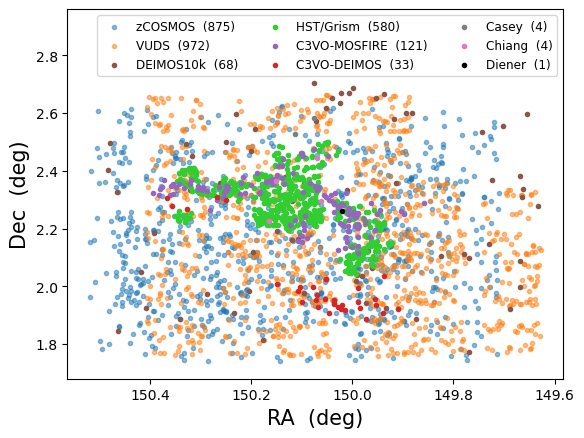

In [15]:
### Spectra in Sky ###
fig = plt.figure()
ax = fig.add_subplot()
s_gp = GalPop.loadFile('OG_Cosmos.npy')

spec_ids = np.where((s_gp.obs_type == 1) & (s_gp.mags['IRAC'] <=25.))[0]

for surv in survey_colors:
    s_use = np.where(s_gp.misc['survey'] == surv)
    if len(s_use[0]) != 0:
        if surv == 'HETDEX': 
            ax.scatter(s_gp.coords[:,0][s_use], s_gp.coords[:,1][s_use],
                    s=9, color=survey_colors[surv][0], alpha=survey_colors[surv][1], label='Chiang'+f'  ({len(s_use[0])})' )
        elif surv == 'HST':
            ax.scatter(s_gp.coords[:,0][s_use], s_gp.coords[:,1][s_use],
                    s=9, color=survey_colors[surv][0], alpha=survey_colors[surv][1], label='HST/Grism'+f'  ({len(s_use[0])})' )
        else:
            ax.scatter(s_gp.coords[:,0][s_use], s_gp.coords[:,1][s_use],
                    s=9, color=survey_colors[surv][0], alpha=survey_colors[surv][1],  label=surv+f'  ({len(s_use[0])})')


ax.set_ylim(1.68, 2.96)
ax.legend(ncols=3, fontsize=8.7)
ax.set_xlabel("RA  (deg)", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("Dec  (deg)", fontsize=15)
plt.savefig("PaperPlots/Spec_Dist.png")

In [16]:
gp_folder = "LP_GalPops/"

### PREP ###
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")

sigs = np.arange(2.0, 5.5, 0.5)

pk_path = "HyperionPeaks/"
pk_sums = [f"peaks_sig{s}.dat" for s in sigs]


cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos_file[1].data
tp = [GalPop.loadFile(gp_folder + f) for f in sorted(os.listdir(gp_folder))]

for t in tqdm(tp):

    # Reset variables
    t.subpops = {}
    t.vols = {}

    # Make a magntiude cut and check mass
    bad = np.where((t.mags['IRAC'] >25.0) | (t.ms < 9.5))
    # bad = np.where((t.mags['IRAC'] >25.0))
    t.del_objs(t.IDs[bad])

    t.subPop("field1", [-99, 4.0], 13. , [2.15, 2.25], pk_path, 'peaks_sig4.0.dat', sig_cube, cosmo = cosmo)
    t.subPop("field2", [-99, 4.0], 13. , [2.8, 2.9], pk_path, 'peaks_sig4.0.dat', sig_cube, cosmo = cosmo)

    # Combine into a field pop
    t.subpops['field'] = np.logical_or(t.subpops['field1'], t.subpops['field2'])


    # make a Hyperion pop
    t.subPop('h2.0', [2.0, np.inf], 13., [2.35, 2.7], pk_path, 'peaks_sig2.0.dat', sig_cube, pk_nums=[1])

    # Find which objects are either field or Hyperion and keep only those
    no_use = np.logical_not(np.logical_or(t.subpops['field'],t.subpops['h2.0']))
    t.del_objs(t.IDs[no_use])


    # Make other hyperion pops
    for si, sigma in enumerate(sigs[1:]):
        t.subPop(f"h{sigma}", [sigma, np.inf], 13., [2.35, 2.7], pk_path, pk_sums[si+1], sig_cube)



  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
tp[0].misc

{'EBV': array([0.2, 0.3, 0.2, ..., 0.1, 0.1, 0.1]),
 'Model': array([ 9,  6, 10, ...,  5,  5, 11], dtype=int64),
 'Ext_law': array([1., 0., 1., ..., 1., 1., 1.]),
 'Age': array([8.26632127, 8.68376447, 8.06765984, ..., 8.65119766, 8.81942005,
        8.19573697])}

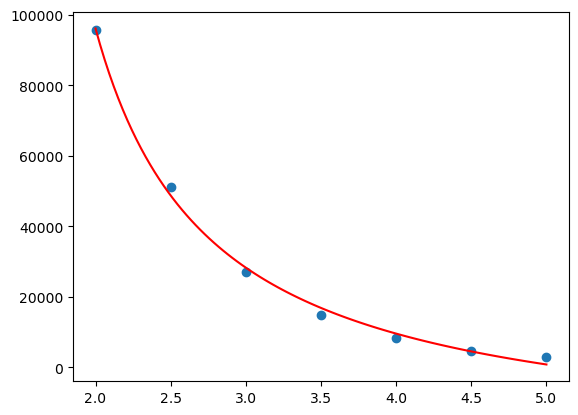

In [18]:
def volF(x, a, b, c, d): return a/(b*x+c) + d

vps, _ = curve_fit(volF,np.arange(2.0,5.5,0.5),list(tp[0].vols.values())[2:]  )


plt.scatter(np.arange(2.0,5.5,0.5),list(tp[0].vols.values())[2:] )
plt.plot(np.linspace(2, 5, 100), volF(np.linspace(2, 5, 100), *vps), color='r')
plt.show()

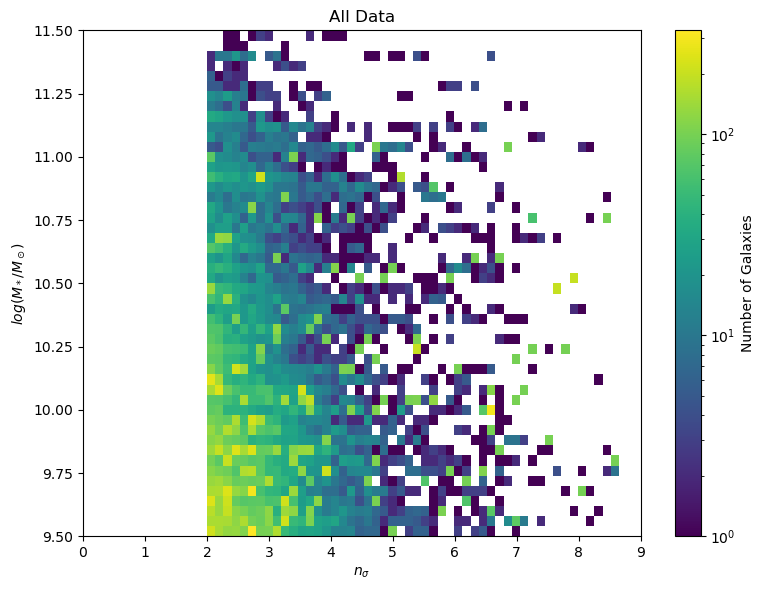

In [19]:
ms, ns = [], []

for t in tp:

    # bad = np.where((t.mags['IRAC'] >25.0) | (t.ms < 9.5) | (t.obs_type == 0))
    bad = np.where((t.mags['IRAC'] >25.0) | (t.ms < 9.5) | (t.obs_type == 20))

    
    t.del_objs(t.IDs[bad])


    # Find only Hyperion members
    t.del_objs( t.IDs[t.pks[2.0]!=1])

    ns.append(t.n_sigmas)
    ms.append(t.ms)

ns = np.concatenate(ns)
ms = np.concatenate(ms)



# Example data (replace with your actual xdata and ydata)
from matplotlib.colors import LogNorm

xdata = ns
ydata = ms

levels = np.logspace(-5, -1, 10)
norm = BoundaryNorm(boundaries=levels, ncolors=256, clip=True)


# Create 2D histogram
plt.figure(figsize=(8, 6))


hist, xedges, yedges, image = plt.hist2d(xdata, ydata, bins=50, cmap='viridis', norm=LogNorm())

# Add colorbar with log scale
cbar = plt.colorbar(image)
cbar.set_label('Number of Galaxies')

# Label axes
plt.xlabel(r'$n_\sigma$')
plt.ylabel(r'$log(M_*/M_\odot)$')
plt.title("All Data")
plt.xlim(0, 9)
plt.ylim(9.5, 11.5)

# Show plot
plt.tight_layout()
plt.show()


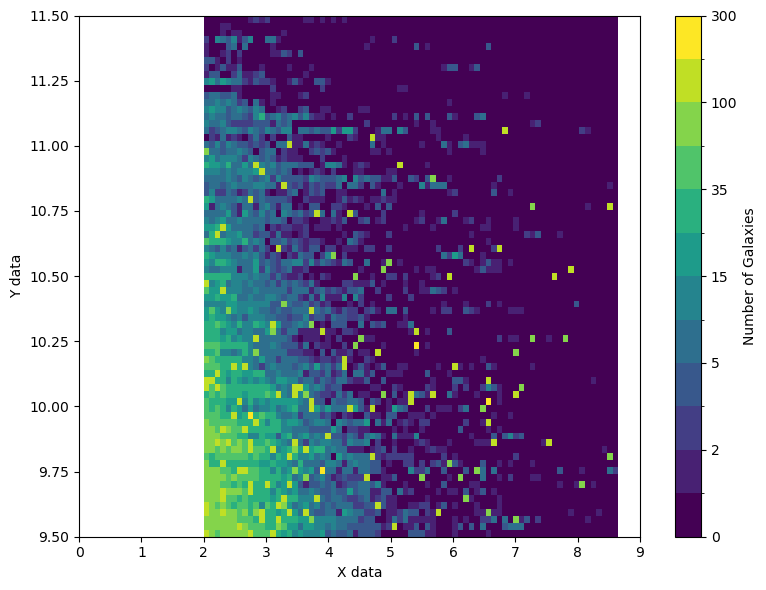

In [20]:
# Example data (replace with your actual xdata and ydata)
from matplotlib.colors import LogNorm

xdata = ns
ydata = ms


levels = np.logspace(0, 2.5, 10)  # Example: 10 discrete levels between 10^0 and 10^3
levels = [0, 1, 2, 3, 5, 10, 15, 20, 35, 50, 100, 200, 300]
norm = BoundaryNorm(boundaries=levels, ncolors=256, clip=True)


# Create 2D histogram
plt.figure(figsize=(8, 6))


hist, xedges, yedges, image = plt.hist2d(xdata, ydata, bins=75, cmap='viridis', norm=norm)

# Add colorbar with log scale
cbar = plt.colorbar(image)
cbar.set_label('Number of Galaxies')

# Label axes
plt.xlabel('X data')
plt.ylabel('Y data')
plt.xlim(0, 9)
plt.ylim(9.5, 11.5)

# Show plot
plt.tight_layout()
plt.show()


[8418, 6268, 5532, 3644, 2885, 2096, 1142, 1064, 951, 645, 812, 434, 471, 965, 270, 560, 111, 505, 106, 213]
[[9.500085554527377, 11.403380569717381], [9.500007942988747, 11.47126149084502], [9.50014255197664, 11.499414677621722], [9.500104875937772, 11.420342007396078], [9.50001718254487, 11.487813364655413], [9.500104875937772, 11.489026547643784], [9.500460914115243, 11.487813364655413], [9.50064731929353, 11.382045025281887], [9.500739854197619, 11.396624140957911], [9.525818178481574, 11.407503961141503], [9.50033187550899, 11.385004393004662], [9.549060027381046, 11.296908079849906], [9.518118967170196, 11.296908079849906], [9.523293401612563, 11.390794031791675], [9.549917390449364, 11.202470527428247], [9.53646500075414, 11.204283769305945], [9.57089599638445, 11.081892782635382], [9.6014334898375, 10.668232959105621], [9.553403605016939, 11.049999023166196], [9.757314869524658, 10.853214229920125]]


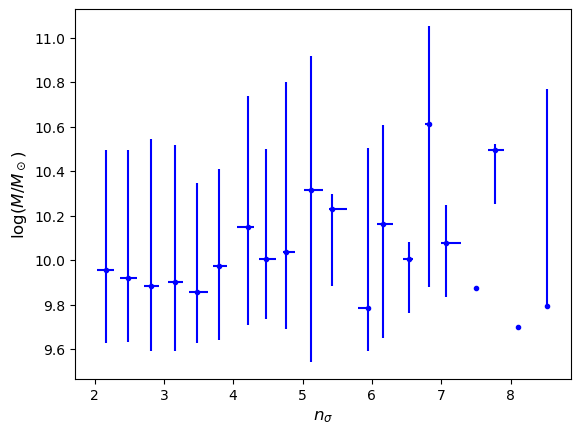

In [21]:
nmax, nstep =  8.5, 1/3
ncut = 2

N=[]
mrange= []


while ncut < nmax:

    idxs = np.where((ns >= ncut) & (ns < ncut + nstep))

    x = np.median(ns[idxs])
    y =  np.median(ms[idxs])
    xr = [x- np.percentile(ns[idxs], [16]) ,  np.percentile(ns[idxs],[84]) -x] 
    yr = [y- np.percentile(ms[idxs], [16]),  np.percentile(ms[idxs],[84]) -y] 


    plt.errorbar(x,y, xerr = xr, yerr= yr, marker='.', color='b')
    N.append(len(ns[idxs]))
    mrange.append([min(ms[idxs]), max(ms[idxs])])

    ncut += nstep

print(N)
print(mrange)

plt.xlabel(r'$n_\sigma$', fontsize=12)
plt.ylabel(r'$\log(M/M_\odot)$', fontsize=12)
plt.show()

In [22]:
# Remove based on IRAC and mass

bad = np.where((s_gp.mags['IRAC'] >25.0) | (s_gp.ms < 9.5))

s_gp.del_objs(s_gp.IDs[bad])


# Find only Hyperion members
s_gp.del_objs( s_gp.IDs[np.logical_not(s_gp.subpops['ho2.0'])])



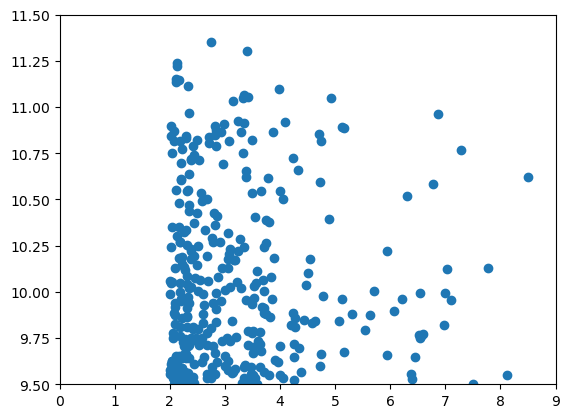

In [23]:
plt.scatter(s_gp.n_sigmas, s_gp.ms)

plt.xlim(0,9)
plt.ylim(9.5, 11.5)
plt.show()

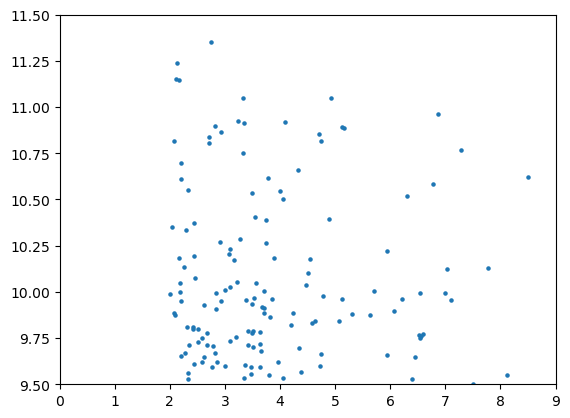

In [24]:
sp_gp = np.where(s_gp.obs_type != 0)

plt.scatter(s_gp.n_sigmas[sp_gp], s_gp.ms[sp_gp], s=5)

plt.xlim(0,9)
plt.ylim(9.5, 11.5)
plt.show()

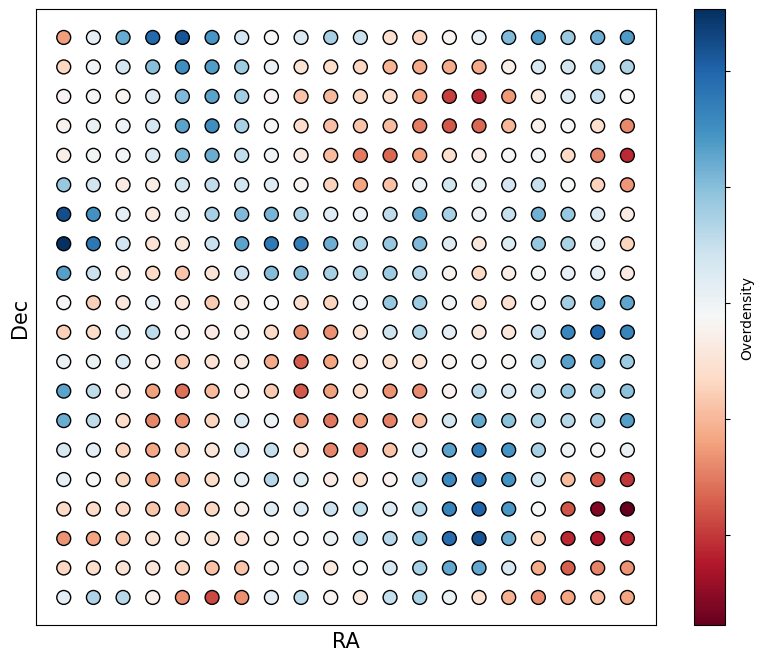

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Parameters
grid_size = 20  # Grid size (20x20)
ra_values = np.linspace(-5, 5, grid_size)
dec_values = np.linspace(-5, 5, grid_size)
ra, dec = np.meshgrid(ra_values, dec_values)

# Randomized overdensity values with some grouping
np.random.seed(42)  # For reproducibility
overdensity = np.random.rand(grid_size, grid_size)

# Apply a Gaussian filter to introduce some grouping
overdensity = gaussian_filter(overdensity, sigma=1)

# Flatten the arrays for plotting
ra_flat = ra.flatten()
dec_flat = dec.flatten()
overdensity_flat = overdensity.flatten()

# Scatter plot with a continuous color scale
plt.figure(figsize=(10, 8))
sc = plt.scatter(ra_flat, dec_flat, c=overdensity_flat, s=100, cmap='RdBu', edgecolor='k')
plt.xlabel('RA', fontsize = 15)
plt.ylabel('Dec', fontsize = 15)
plt.yticks([])
plt.xticks([])
plt.grid(False)

# Add a colorbar without numerical labels, just to indicate color differences
cbar = plt.colorbar(sc)
cbar.ax.set_yticklabels([])  # Remove numerical labels
cbar.set_label('Overdensity')

plt.show()


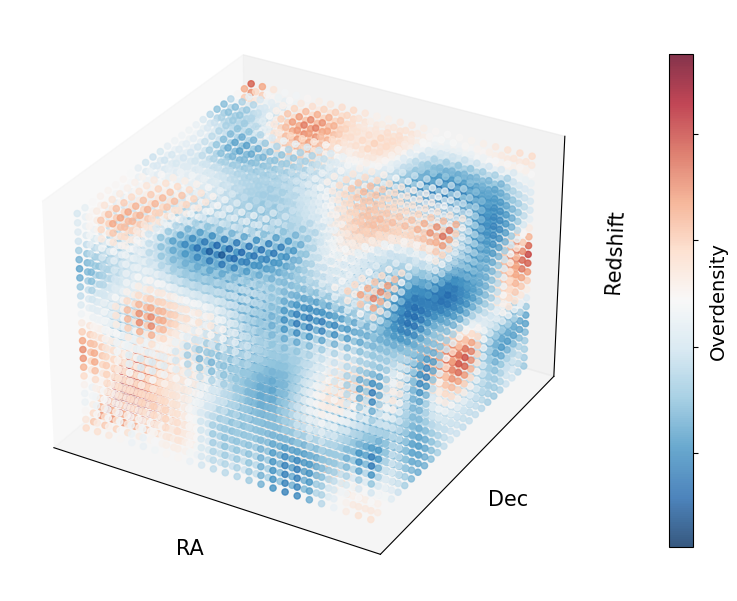

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Parameters
grid_size = 25  # Grid size (10x10x10)
ra_values = np.linspace(-5, 5, grid_size)
dec_values = np.linspace(-5, 5, grid_size)
z_values = np.linspace(0, 10, grid_size)  # Redshift

# Create a 3D grid
ra, dec, z = np.meshgrid(ra_values, dec_values, z_values)

# Randomized overdensity values with some grouping

np.random.seed(41)  # For reproducibility           ## SUPER LOW AVG OD
np.random.seed(27)



overdensity = np.random.rand(grid_size, grid_size, grid_size)

# Apply a Gaussian filter to introduce some grouping
overdensity = gaussian_filter(overdensity, sigma=2.)
overdensity = np.exp(overdensity)

# Flatten the arrays for plotting
ra_flat = ra.flatten()
dec_flat = dec.flatten()
z_flat = z.flatten()
overdensity_flat = overdensity.flatten()

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with a continuous color scale
sc = ax.scatter(ra_flat, dec_flat, z_flat, c=overdensity_flat, cmap='RdBu_r', s=20, alpha=0.8)

# Labels and title
ax.set_xlabel('RA', fontsize=15)
ax.set_ylabel('Dec', fontsize=15)
ax.set_zlabel('Redshift', fontsize=15)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Add a colorbar without numerical labels
cbar = fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.1)  # Shrink and pad adjust the position of the colorbar
cbar.ax.tick_params(labelsize=12)  # Increase tick label size
cbar.ax.set_yticklabels([])  # Remove numerical labels if you don't want them
cbar.set_label('Overdensity', fontsize=14)  # Increase colorbar label size

plt.show()


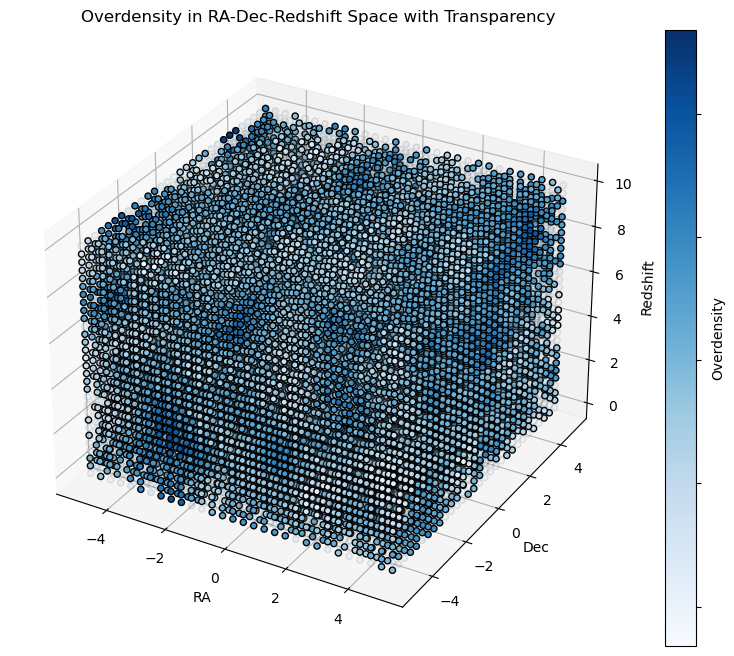

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors

# Parameters
grid_size = 30  # Grid size (10x10x10)
ra_values = np.linspace(-5, 5, grid_size)
dec_values = np.linspace(-5, 5, grid_size)
z_values = np.linspace(0, 10, grid_size)  # Redshift

# Create a 3D grid
ra, dec, z = np.meshgrid(ra_values, dec_values, z_values)

# Randomized overdensity values with some grouping
np.random.seed(42)  # For reproducibility
overdensity = np.random.rand(grid_size, grid_size, grid_size)

# Apply a Gaussian filter to introduce some grouping
overdensity = gaussian_filter(overdensity, sigma=1.5)

# Flatten the arrays for plotting
ra_flat = ra.flatten()
dec_flat = dec.flatten()
z_flat = z.flatten()
overdensity_flat = overdensity.flatten()

# Determine a threshold for transparency
threshold = np.percentile(overdensity_flat, 35)  # 35% of points will be nearly transparent

# Set transparency based on the overdensity values
alpha_values = np.where(overdensity_flat < threshold, 0.1, 1.0)  # 0.1 for low overdensities, 1.0 for high

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with a continuous color scale (Blues) and varying alpha
sc = ax.scatter(ra_flat, dec_flat, z_flat, c=overdensity_flat, cmap='Blues', s=20, edgecolor='k', alpha=alpha_values)

# Labels and title
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_zlabel('Redshift')
ax.set_title('Overdensity in RA-Dec-Redshift Space with Transparency')

# Add a colorbar without numerical labels
cbar = fig.colorbar(sc, ax=ax)
cbar.ax.set_yticklabels([])  # Remove numerical labels
cbar.set_label('Overdensity')

plt.show()


In [28]:
### Cosmos Gal Pop ###
sig_cube = fits.open(r"C:\Users\sikor\OneDrive\Desktop\benpy\ThirdTry\Hyperion_interpolated_cube_sigma.fits")
sigs = [2.0, 2.5, 3.0, 4.0, 5.0]
sig_folders = [f"\sig{s}_peaks" for s in sigs]
pk_path = "HyperionPeaks/"
pk_sums = [f"peaks_sig{s}.dat" for s in sigs]

final_tot = GalPop.loadFile("OG_Cosmos.npy")
# final_tot.assignPeaks(sigs, sig_cube, pk_path, pk_sums, sig_folders, overwrite=True)
plot_f = GalPop(IDs = final_tot.IDs, ms= final_tot.ms, coords=final_tot.coords,
                SFRs=final_tot.SFRs, obs_type=final_tot.obs_type,pks=final_tot.pks )

# h_objs = np.where(final_tot.mags['IRAC'] <= 25.0)
h_objs = np.where((final_tot.pks[2.0] == 1) & (final_tot.mags['IRAC'] <= 25.))[0]

# h_objs = np.where(final_tot.pks[2.0] == 1)
plot_folder = "None"

temp = {}
for k in final_tot.pks:
    temp[k] = final_tot.pks[k][h_objs]

plot_h = GalPop(IDs = final_tot.IDs[h_objs], ms= final_tot.ms[h_objs], 
                coords=final_tot.coords[h_objs].astype(float),obs_type=final_tot.obs_type[h_objs],pks=temp )
# too_small = np.where(plot_tot.ms < 9.0)
# not_Hyp = np.where(plot_h.pks[2.0] != 1)
# plot_h.del_objs(plot_h.IDs[not_Hyp])
# plot_tot.del_objs(plot_tot.IDs[too_small])


plot_f.subPop("field1", [-99, 4.0], 13. , [2.15, 2.25], pk_path, "peaks_sig4.0.dat", sig_cube, cosmo = cosmo, plot=plot_folder)
plot_f.subPop("field2", [-99, 4.0], 13. , [2.8, 2.9], pk_path, "peaks_sig4.0.dat", sig_cube, cosmo = cosmo, plot=plot_folder)

for si, sigma in enumerate(sigs):
    print(sigma)
    plot_h.subPop(f"o{sigma}", [sigma, np.inf], 13., [2.35, 2.7], pk_path, pk_sums[si], sig_cube, plot=plot_folder)

2.0
2.5
3.0
4.0
5.0


In [29]:
len(np.where(plot_h.obs_type==0)[0]) / len(plot_h.obs_type)
# len(np.where(plot_h.obs_type==1)[0])
# len(np.where(plot_h.obs_type==2)[0])

0.6445131375579598

In [30]:
len(np.where(final_tot.pks[2.0] ==2)[0])

89

In [31]:
a = np.unique(plot_h.pks[4.0][plot_h.subpops['o4.0']])

In [32]:
np.max(plot_h.coords[:,2][plot_h.subpops['o4.0']])

2.555799961090088

In [33]:
h = np.genfromtxt('HyperionPeaks\peaks_sig4.0.dat')
sum(h[:,10][a.astype(int)-1])

8393.8173

In [34]:
def popPlot2(obj, sp_key, xlims, ylims, zlims, az, el):
    ots = [0,1,2]
    ot_cs = ['tab:blue', 'tab:orange', 'tab:green']
    ot_label = ['COSMOS2020', 'Spectroscopy', 'HST Grism']
    s_gals = 40

    g_ids = obj.subpops[sp_key]

    # Sample data: replace with your actual data
    RA = obj.coords[:,0][g_ids]  # Right Ascension
    Dec = obj.coords[:,1][g_ids]  # Declination
    redshift =obj.coords[:,2][g_ids]  # Redshift

    fig = plt.figure(figsize=(8,18))
    ax = fig.add_subplot(111, projection='3d')

    for idx in range(len(ots)):
        plot_ids = np.where(obj.obs_type[g_ids]==ots[idx])
        if len(plot_ids[0])>0:
            ax.scatter(RA[plot_ids], Dec[plot_ids], redshift[plot_ids], marker='.', s=s_gals,
                        c=ot_cs[idx], label=f"{ot_label[idx]} : {len(plot_ids[0])}")

    # Contour on x-y plane
    xy = np.vstack([RA, Dec])
    kde = gaussian_kde(xy)
    xgrid = np.linspace(xlims[0], xlims[1], 200)
    ygrid = np.linspace(ylims[0], ylims[1], 200)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    ax.contour(X, Y, Z, levels=20, cmap='spring', offset=zlims[0], zdir='z')  # Ensure the offset aligns with the z-axis limit

    # Contour on x-z plane
    xz = np.vstack([RA, redshift])
    kde = gaussian_kde(xz)
    xgrid = np.linspace(xlims[0], xlims[1], 200)
    zgrid = np.linspace(zlims[0], zlims[1], 200)
    X, Z = np.meshgrid(xgrid, zgrid)
    Y = kde(np.vstack([X.ravel(), Z.ravel()])).reshape(X.shape)

    ax.contour(X, Y, Z, levels=10, cmap='autumn', offset=ylims[0], zdir='y')  # Ensure the offset aligns with the y-axis limit
    ax.set_xlabel('\nRA', fontsize=15)
    ax.set_ylabel('\nDec', fontsize=15)
    ax.set_zlabel('\nRedshift', fontsize=15)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)
    ax.set_xticks(np.linspace(xlims[0], xlims[1], num=5))
    ax.set_yticks(np.linspace(ylims[0], ylims[1], num=8))


    ax.legend(title="Source of Redshift", title_fontsize=12)

    # Adjust the viewing angle
    ax.set_box_aspect(aspect=(1,1,1.5), zoom=1.1)
    ax.invert_xaxis()
    ax.view_init(elev=el, azim=az)  # Experiment with different elevation and azimuth angles

    plt.show()

In [35]:
np.sum(10**np.array([14.3, 14.0, 13.5, 13.9, 13.6, 13.3, 13.6, 13.1, 13]) / 10**15.7101)

0.10385310818752609

In [36]:
np.unique(plot_h.pks[4.0][plot_h.subpops['o4.0']])

array([ 1.,  2.,  4.,  5.,  8.,  9., 13., 17., 24., 25., 39.])

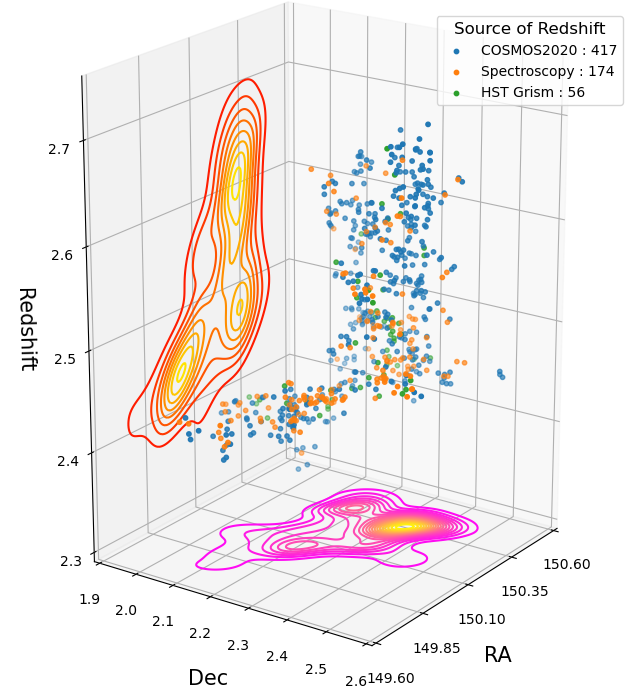

In [37]:
xs = (149.6, 150.6)
ys = (1.9, 2.6)
zs = (2.3, 2.75)

popPlot2(plot_h, 'o2.0', xs, ys, zs, 35, 20)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.stats import gaussian_kde

def popPlot2_animate(obj, sp_key, xlims, ylims, zlims, save_gif=False):
    ots = [0, 1, 2]
    ot_cs = ['tab:blue', 'tab:orange', 'tab:green']
    ot_label = ['COSMOS2020', 'Spectroscopy', 'HST Grism']
    s_gals = 40

    g_ids = obj.subpops[sp_key]

    # Sample data: replace with your actual data
    RA = obj.coords[:, 0][g_ids]  # Right Ascension
    Dec = obj.coords[:, 1][g_ids]  # Declination
    redshift = obj.coords[:, 2][g_ids]  # Redshift

    # Create figure and 3D axis
    fig = plt.figure(figsize=(8, 18))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the data
    for idx in range(len(ots)):
        plot_ids = np.where(obj.obs_type[g_ids] == ots[idx])
        if len(plot_ids[0]) > 0:
            ax.scatter(RA[plot_ids], Dec[plot_ids], redshift[plot_ids], marker='.', s=s_gals,
                       c=ot_cs[idx], label=f"{ot_label[idx]} : {len(plot_ids[0])}")



    # Configure axis
    ax.set_xlabel('\nRA', fontsize=15)
    ax.set_ylabel('\nDec', fontsize=15)
    ax.set_zlabel('\nRedshift', fontsize=15)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)
    ax.set_xticks(np.linspace(xlims[0], xlims[1], num=5))
    ax.set_yticks(np.linspace(ylims[0], ylims[1], num=8))
    ax.invert_xaxis()

    # Legend
    ax.legend(title="Source of Redshift", title_fontsize=12)

    # Adjust the viewing angle and aspect ratio
    ax.set_box_aspect(aspect=(1, 1, 1.5))
    
    # Animation function to rotate the view
    def update_view(i):
        # Print progress for every 50 frames
        if i % 50 == 0:
            print(f"Frame: {i}")

        if i < 15:
            # Hold the RA-Dec view (sky view) for 15 frames
            ax.view_init(elev=90, azim=0)
        
        elif i < 105:
            # Tip down to view edge-on from the RA-Dec plane over the next 90 frames
            ax.view_init(elev=90 - (i - 15), azim=0)
        
        elif i < 195:
            # Rotate 90 degrees while edge-on over the next 90 frames
            ax.view_init(elev=0, azim=(i - 105))
        
        elif i < 285:
            # Rotate back 90 degrees edge-on over the next 90 frames
            ax.view_init(elev=0, azim=90 - (i - 195))
        
        elif i < 375:
            # Tip back up to the original RA-Dec view over the last 90 frames
            ax.view_init(elev=(i - 285), azim=0)

        else: 
            ax.view_init(elev=90, azim=0)



    # Create the animation
    ani = FuncAnimation(fig, update_view, frames=390, interval=50)

    # Save as a GIF if required
    if save_gif:
        writer = PillowWriter(fps=20)
        ani.save("galaxy_rotation.gif", writer=writer)
        print("GIF saved!")

    plt.show()

# Example usage:
# popPlot2_animate(obj, sp_key, xlims, ylims, zlims, save_gif=True)


In [39]:
xs = (149.6, 150.6)
ys = (1.9, 2.6)
zs = (2.3, 2.75)

# popPlot2_animate(plot_h, 'o2.0', xs, ys, zs, save_gif=True)

In [40]:
10**14.3058

202208775840144.22

In [41]:
ra_range = (149.65, 150.47)
dec_range = (2.02, 2.56)
z_range = (2.35, 2.70)
c_coords = plot_h.coords[plot_h.subpops['o2.0']]
print(np.min(c_coords, axis=0),np.max(c_coords, axis=0))

[149.66086131   2.02745487   2.3599    ] [150.46551514   2.55440653   2.6973    ]


In [42]:
np.min(plot_h.coords[:,0]), np.min(plot_h.coords[:,1])  # RA and Dec of the first point


(149.66086130857863, 2.0274548741841314)

In [43]:
np.max(plot_h.coords[:,0]), np.max(plot_h.coords[:,1])

(150.46551513671875, 2.554406528959089)

In [44]:
np.min(plot_h.coords[:,2]), np.max(plot_h.coords[:,2])

(2.3599, 2.6973)

In [45]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo  # You can replace Planck18 with your preferred cosmology model

# Define RA and Dec for two points (in degrees)
ra1, dec1 = np.min(plot_h.coords[:,0]), np.average(plot_h.coords[:,1])  # RA and Dec of the first point
ra2, dec2 = np.max(plot_h.coords[:,0]), np.average(plot_h.coords[:,1])  # RA and Dec of the second point

# ra1, dec1 = ra_range[0], dec_range[0]  # RA and Dec of the first point
# ra2, dec2 = ra_range[1], dec_range[0]  # RA and Dec of the second point

# Convert RA and Dec to SkyCoord objects
coord1 = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree, frame='icrs')
coord2 = SkyCoord(ra=ra2*u.degree, dec=dec2*u.degree, frame='icrs')

# Calculate the angular separation
angular_separation = coord1.separation(coord2)
print(f"Angular separation: {angular_separation.to(u.arcmin)}")

# Define the redshift
redshift = 2.5

ctd = cosmo.comoving_transverse_distance(redshift)


# Calculate the transverse comoving distance (in the plane of the sky)
print(f"Transverse comoving distance: {ctd*angular_separation.to(u.rad)}")


Angular separation: 48.24065609075602 arcmin
Transverse comoving distance: 83.73368207746255 Mpc rad


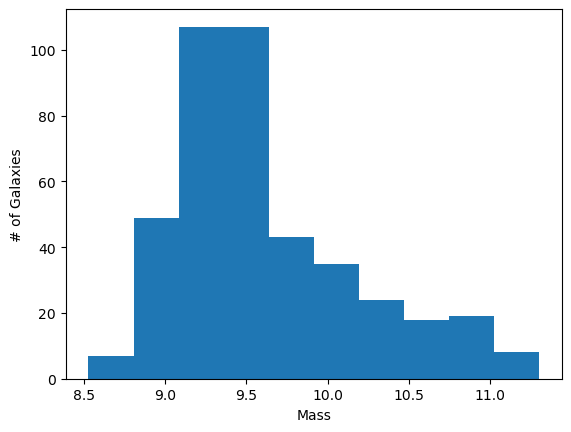

In [46]:
s_cut = 'o2.0'
g_ms = np.where((plot_h.ms[plot_h.subpops[s_cut]] > 0) & (plot_h.obs_type[plot_h.subpops[s_cut]] ==0 )    )
plt.hist(plot_h.ms[plot_h.subpops[s_cut]][g_ms], bins=10)
plt.xlabel("Mass")
plt.ylabel("# of Galaxies")
plt.show()

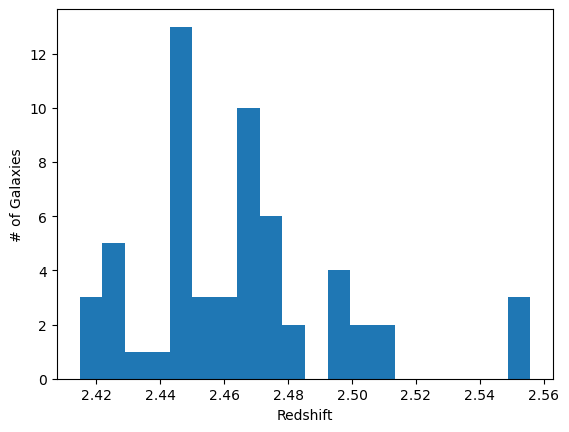

In [47]:
s_cut = 'o4.0'
g_ms = np.where((plot_h.ms[plot_h.subpops[s_cut]] > 0) & (plot_h.obs_type[plot_h.subpops[s_cut]] ==1 )    )
plt.hist(plot_h.coords[:,2][plot_h.subpops[s_cut]][g_ms], bins=20)
plt.xlabel("Redshift")
plt.ylabel("# of Galaxies")
plt.show()

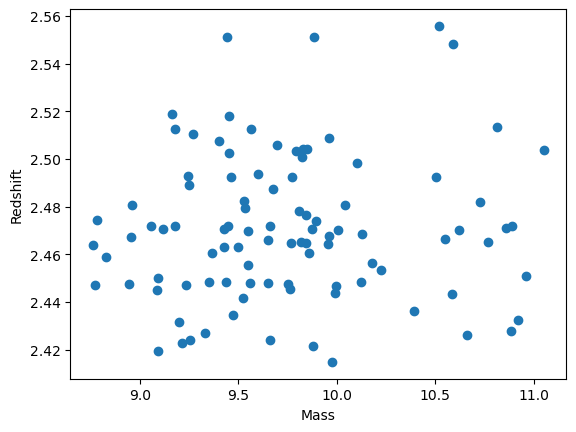

In [48]:
s_cut = 'o4.0'
g_ms = np.where((plot_h.ms[plot_h.subpops[s_cut]] > 0) & (plot_h.obs_type[plot_h.subpops[s_cut]] >=0)    )
plt.scatter(plot_h.ms[plot_h.subpops[s_cut]][g_ms], plot_h.coords[:,2][plot_h.subpops[s_cut]][g_ms])
plt.xlabel("Mass")
plt.ylabel("Redshift")
plt.show()

In [49]:
### BUILD SMFs ###
sp_keys = [['field1', 'field2']] + [f'o{s}' for s in sigs] 
smf_keys = ['field'] + [f'o{s}' for s in sigs] 

m_range = [9., 11.5, 0.5]
plot_f.make_SMF(sp_keys[:1], smf_keys[:1] ,m_range)


plot_h.make_SMF(smf_keys[1:], smf_keys[1:], m_range)


### Plot all smfs ###
colors = ['tab:purple', 'tab:blue','tab:green', 'tab:orange', 'tab:red']  
shapes = ["o", "H", "P", "s", "D", (5,1,0)]
labels = ['field', "o2.0", "o2.5", "o3.0", "o4.0"]

for ki, k in enumerate(smf_keys):
    print(k)
    if ki == 0:
        plt.scatter(plot_f.smfs[k][:,0],plot_f.smfs[k][:,2], color=colors[ki], label=labels[ki], marker=shapes[ki] )
    else:
        plt.scatter(plot_h.smfs[k][:,0],plot_h.smfs[k][:,2], color=colors[ki], label=labels[ki], marker=shapes[ki] )

plt.yscale('log')
plt.legend(loc='lower left')
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

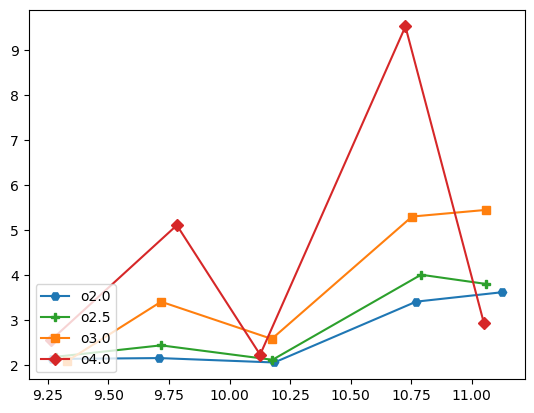

In [29]:
### BUILD SMFs ratio ###

### Plot all smfs ###
colors = [ 'tab:blue','tab:green', 'tab:orange', 'tab:red']  
shapes = [ "H", "P", "s", "D", (5,1,0)]
labels = ["o2.0", "o2.5", "o3.0", "o4.0"]

for ki, k in enumerate(smf_keys[1:]):
    plt.plot(plot_h.smfs[k][:,0],plot_h.smfs[k][:,2] / plot_f.smfs['field'][:,2], color=colors[ki], label=labels[ki], marker=shapes[ki] )


plt.legend(loc='lower left')
plt.show()

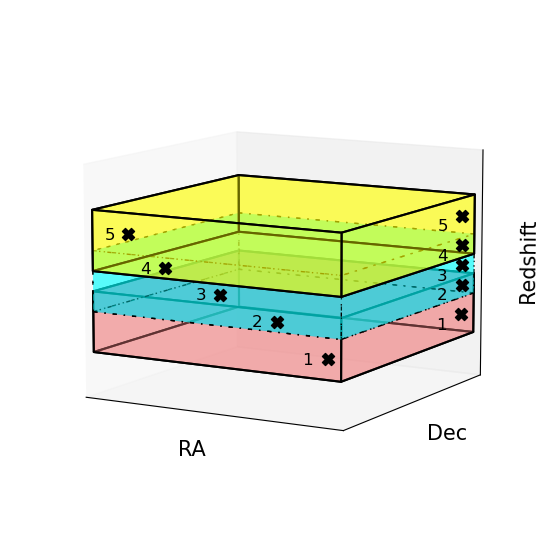

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Create a figure
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d',computed_zorder=False)

# Function to create a rectangular prism (slice)
def create_prism(x_range, y_range, z_range, color, alpha, lw, ls, zo):
    # Define vertices for a rectangular prism
    vertices = [[x_range[0], y_range[0], z_range[0]],
                [x_range[1], y_range[0], z_range[0]],
                [x_range[1], y_range[1], z_range[0]],
                [x_range[0], y_range[1], z_range[0]],
                [x_range[0], y_range[0], z_range[1]],
                [x_range[1], y_range[0], z_range[1]],
                [x_range[1], y_range[1], z_range[1]],
                [x_range[0], y_range[1], z_range[1]]]
    
    # Define the 6 faces of the prism (each face is a quadrilateral)
    faces = [[vertices[j] for j in [0, 1, 2, 3]], 
             [vertices[j] for j in [4, 5, 6, 7]], 
             [vertices[j] for j in [0, 3, 7, 4]], 
             [vertices[j] for j in [1, 2, 6, 5]], 
             [vertices[j] for j in [0, 1, 5, 4]], 
             [vertices[j] for j in [2, 3, 7, 6]]]
    
    # Create a 3D polygon collection for the prism
    prism = Poly3DCollection(faces, facecolors=color, linewidths=lw, linestyle=ls, edgecolors='k', alpha=alpha, zorder=zo)
    
    return prism

# Define the ranges for RA-Dec and Redshift
x_range = [0, 10]  # RA range
y_range = [0, 10]  # Dec range
z_ranges = [[2, 5], [4, 7], [6, 9], [4,5]]  # Redshift slices with ~50% overlap

# Define colors and transparency for each slice
colors = ['lightcoral', 'cyan', 'yellow', 'darkmagenta']
lws = [1.5, 1, 1.5, 1]
lss = ['solid', (0, (3, 5, 1, 5)), 'solid', (0, (3, 5, 1, 5))]
zorders=[0.1,0.2,0.3,0.05]
alpha = 0.4  # Lower transparency for clarity

# Create and add prisms to the plot
for i, z_range in enumerate(z_ranges):
    prism = create_prism(x_range, y_range, z_range, colors[i], alpha, lws[i], lss[i], zorders[i])
    ax.add_collection3d(prism)

# Add example galaxies at dec=0
def add_gal(x, y, z, txt):
    ax.scatter(x, y, z, marker='X', color='k', s=75,zorder=1)
    if y==0:
        ax.text(x-1, y, z-0.4, txt, fontsize=12)
    else:
        ax.text(x-0.5, y-1., z-0.65, txt, fontsize=12)


gals = [[9.5,0,3,"1"], [7.5,0,4.5, "2"], [5.25,0, 5.5, "3"], [3, 0,6.5, "4"], [1.5,0, 8, "5"],
        [9.75,9.5,3,"1"], [9.75,9.5,4.5,"2"],[9.75,9.5,5.5,"3"], [9.75,9.5,6.5,"4"], [9.75,9.5,8,"5"] ]

for g in gals:
    add_gal(*g)

# Set axis labels
ax.set_xlabel( 'RA')
ax.set_ylabel('Dec')
ax.set_zlabel('Redshift')

# Set axis limits for clarity
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_zlim(0, 11)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.zaxis.label.set_fontsize(15)


ax.set_box_aspect((5,5,4), zoom=0.85)


ax.view_init(elev=10)
plt.savefig("PaperPlots/3dVMC.png")


C:\Users\sikor\AppData\Local\Temp\ipykernel_7856\505252112.py:115: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



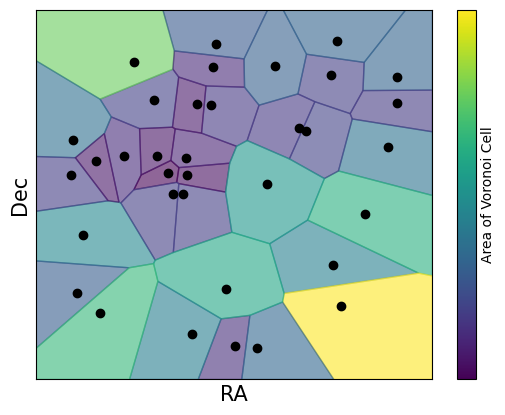

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, box  # For clipping polygons
from matplotlib import cm

def voronoi_finite_polygons_2d(vor, radius=None):
    # Same function as before...

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1] 
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# Function to calculate the area of a clipped polygon
def clipped_polygon_area(vertices, clip_box):
    polygon = Polygon(vertices)
    clipped_polygon = polygon.intersection(clip_box)
    return clipped_polygon.area

# Generate points
np.random.seed(1234)
points = np.random.rand(35, 2)

# Compute Voronoi tesselation
vor = Voronoi(points)

# Get regions and vertices
regions, vertices = voronoi_finite_polygons_2d(vor)

# Define the clipping box (plot limits)
x_min, x_max = vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1
y_min, y_max = vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1
clip_box = box(x_min, y_min, x_max, y_max)

# Calculate area for each region
areas = []
for region in regions:
    polygon = vertices[region]
    area = clipped_polygon_area(polygon, clip_box)
    areas.append(area)

# Normalize areas for color mapping
areas = np.array(areas)
norm = plt.Normalize(areas.min(), areas.max())
cmap = cm.viridis  # Choose a colormap

# Plot Voronoi cells with colors based on area
for region, area in zip(regions, areas):
    polygon = vertices[region]
    clipped_polygon = Polygon(polygon).intersection(clip_box)
    if not clipped_polygon.is_empty:
        plt.fill(*zip(*clipped_polygon.exterior.coords), color=cmap(norm(area)), alpha=0.6)

# Plot original points
plt.plot(points[:, 0], points[:, 1], 'ko')

# Set plot limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks([])
plt.yticks([])
plt.xlabel("RA", fontsize=15)
plt.ylabel('Dec', fontsize=15)
# Add colorbar for reference
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Area of Voronoi Cell', ticks=[])

# Show plot
plt.savefig("PaperPlots/2dVMC.png")


---
---
---
---
---
---
---
---
---
---


In [3]:
## READ IN FILE ##
cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos_file[1].data

## FIND BAD GALAXIES ##
bad_ids = np.where((np.isnan(c20p["lp_zPDF"]) == True) |        # No redshift from lephare
                   (np.isnan(c20p["lp_zPDF_l68"]) == True) |    # No lower-68-percentile from lephare
                   (np.isnan(c20p["lp_zPDF_u68"]) == True))[0]  # no upper-68-percentile from lephare

print(f"Number of Objects = {len(c20p)}")
print(f"Number of bad Objects = {len(bad_ids)}")

### Delete bad data ###
new_c = np.delete(c20p, bad_ids)

Number of Objects = 1720700
Number of bad Objects = 19258


In [112]:
### Cut to galaxies ###
c_gals = new_c[np.where((new_c["lp_type"] == 0) | (new_c["lp_type"] == 2))[0]]
print(f"Number of Galaxies = {len(c_gals)}")

Number of Galaxies = 1670900


In [117]:
### Check skewness of dist ###
check1 = np.where(((c_gals["lp_zPDF_u68"] - c_gals["lp_zPDF"] ) / (c_gals["lp_zPDF"] - c_gals["lp_zPDF_l68"] ) )> 5.35 )[0]
print(len(check1))

67856


In [122]:
## Check bimodality ##
check2 = np.where((np.isnan(c_gals["lp_zp_2"])) |
    ((np.isnan(c_gals["lp_zp_2"]) == False) & (np.abs((c_gals["lp_zp_2"]-c_gals["lp_zPDF"]) / (1+c_gals["lp_zPDF"])) < 0.5) ))[0]
print(len(check2))

1485108


In [116]:
print(c_gals["lp_zPDF"])
print(c_gals["lp_zp_2"])
print(c_gals["lp_zPDF_l68"])
print(c_gals["lp_zPDF_u68"])


[1.8446 1.4089 1.5084 ... 1.3664 6.0346 3.2942]
[ nan 0.83 1.19 ... 1.68 3.69 2.84]
[1.6362 1.0645 1.2601 ... 0.6067 4.2988 1.0582]
[2.0925 1.825  1.6721 ... 3.3365 6.9337 5.6556]


In [144]:
median = c_gals["lp_zPDF"]
lower_bound = c_gals["lp_zPDF_l68"]
upper_bound = c_gals["lp_zPDF_u68"]
zrange = upper_bound - lower_bound
pk2 = c_gals["lp_zp_2"]

# Compute differences and scale
delta_lower = median - lower_bound
delta_upper = upper_bound - median
scale = (upper_bound - lower_bound) / 2

# Generalized skewness parameter
alpha = (delta_upper - delta_lower) / scale
# # Calculate delta
delta = alpha / np.sqrt(1 + alpha**2)
gamma = (4-np.pi)/2 * (delta*np.sqrt(np.pi/2))**3 / (1-2*delta**2/np.pi)**1.5

In [192]:
c1 = (3.2-1.75)/(3)
print(c1)

0.4833333333333334


In [193]:
new_bad = np.where(
        ( zrange/ (1+median)  > 0.5)            # Make sure the median is well-constrained
        | ( (np.abs(gamma) > 0.995) &  (zrange/(1+ median) > 0.25 )  )         # Skewness is too large for redshift range
        | ((np.isnan(pk2) == False)  & (np.abs(pk2-median) / (1+median) > 1 ))
        )[0]

In [194]:
final_c20 = np.delete(c_gals, new_bad)

In [195]:
final_c20.shape

(1326004,)

In [287]:
c_id = 10

c_a, c_b, c_c = c20p["lp_zPDF_l68"][c_id], c20p["lp_zPDF"][c_id],  c20p["lp_zPDF_u68"][c_id]
print(c_a, c_b, c_c)
print(c20p["lp_zp_2"][c_id])

1.696 1.7905 1.9045
nan


Cosmos ID =  8
z_low =  1.3273    (-0.582)
z_med =  1.9093
z_high =  2.3856    (0.476)
Second z-peak -->    2.26

Initial guesses:
         0.71
         -26.59
         2.56

Convergence result = True  in 29 iterations
Residual =  1.5359703451413786e-15


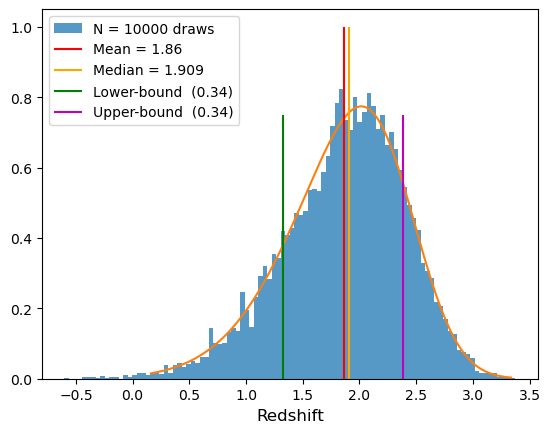

In [8]:
import numpy as np
from scipy.stats import skewnorm
from scipy.optimize import minimize

# Define the target percentiles
c_id = 7

a, b, c = c20p["lp_zPDF_l68"][c_id], c20p["lp_zPDF"][c_id],  c20p["lp_zPDF_u68"][c_id]


# Define a function that calculates the area mismatch
def objective(params):
    omega, alpha, loc = params
        
    dist = skewnorm(alpha, loc=loc, scale=omega)

    vals = dist.ppf([0.16, 0.5, 0.84])
    # Calculate the CDF at points a, b, and c
    cdf_a = dist.cdf(a)
    cdf_b = dist.cdf(b)
    cdf_c = dist.cdf(c)
    
    # The areas we want to match
    area_left = cdf_b - cdf_a
    area_right = cdf_c - cdf_b
    
    # Objective is to make both areas equal to 0.34
    return (area_left - 0.34)**2 + (area_right - 0.34)**2 + (dist.median() -b)**2



guess_w = 2/3*(c-a)
if (b-a) < (c-b):
    guess_l = a - guess_w/(4)
    a_fact = 1
else:
    guess_l = c + guess_w/(4)
    a_fact=-1
v = ((b-a)**2 + (c-b)**2)/2

d = np.sqrt(  np.pi/2 * (1-v/guess_w**2))
guess_a = 50*v**0.5
# Initial guess for omega and alpha
initial_guess = [0.1,3, b]
initial_guess = [guess_w, a_fact*guess_a, guess_l]


# Minimize the objective function
result = minimize(objective, initial_guess, tol=1e-14, options={'maxiter':1000},
                  bounds = ((0, 1), (-10, 10), (0, 3)))

# Extract optimized parameters
omega_opt, alpha_opt, loc_opt = result.x
final_dist = skewnorm(alpha_opt, loc=loc_opt, scale=omega_opt)
final = final_dist.rvs(10000)
print("Cosmos ID = ", c20p["ID"][c_id])
print("z_low = ", a, f"   ({round(a-b, 3)})")
print("z_med = ", b)
print("z_high = ", c, f"   ({round(c-b, 3)})")
print("Second z-peak -->   ", c20p["lp_zp_2"][c_id])
print()
print("Initial guesses:")
for ig in initial_guess: print("        ", round(ig, 2))
print()
print(f"Convergence result = {result.success}  in {result.nit} iterations")
print("Residual = ", objective(result.x))

delta =alpha_opt / np.sqrt(1 +alpha_opt**2)
gamma = (4-np.pi)/2 * (delta*np.sqrt(np.pi/2))**3 / (1-2*delta**2/np.pi)**1.5
mu = final_dist.mean()
final_med = final_dist.median()

# Final skew-normal distribution
p_l68 = final_dist.cdf(b) - final_dist.cdf(a)
p_u68 = final_dist.cdf(c) - final_dist.cdf(b)
xs = np.linspace(b-3*(b-a), b+3*(c-b), 1000)
# plt.title(rf"$\omega$={round(omega_opt, 2)}     $\alpha$={round(alpha_opt, 2)}     $\xi$={round(loc_opt, 2)}    $\gamma$={round(gamma, 2)}")
plt.hist(final, density=True, bins=100, label=f"N = {10000} draws", alpha=0.75)
plt.plot(xs, final_dist.pdf(xs))
plt.vlines(mu, ymin=0, ymax=1., color='red', label=f"Mean = {round(mu, 3)}")
plt.vlines(final_med, ymin=0, ymax=1, color='orange', label=f"Median = {round(final_med, 3)}")
plt.vlines(a, ymin=0, ymax=0.75, color='g', label=f"Lower-bound  ({round(p_l68,3)})")
plt.vlines(c, ymin=0, ymax=3/4, color='m', label=f"Upper-bound  ({round(p_u68, 3)})")
plt.xlabel('Redshift', fontsize=12)
# plt.vlines(mu+0.5, ymin=0, ymax=1, color='gold', label=rf"$\mu$+0.5   ({round(final_dist.cdf(mu+0.5)-final_dist.cdf(mu), 2)})")
# plt.vlines(mu-0.5, ymin=0, ymax=1, color='gold', label=rf"$\mu$-0.5   ({round(final_dist.cdf(mu)-final_dist.cdf(mu-0.5), 2)})")
plt.legend()
plt.show()

In [105]:
a = 1.73
b = 2
c = 2.61

d1 = b-a
d2 = c-b
print(d1, d2, d1/b, d2/b, d2/d1, 11*(c-a))

0.27 0.6099999999999999 0.135 0.30499999999999994 2.2592592592592586 9.68


In [152]:
a = 1.85
b = 2
c = 2.3
guess_w = 2/3*(c-a)
guess_l = a - guess_w/(4)
v = ((b-a)**2 + (c-b)**2)/2

d = np.sqrt(  np.pi/2 * (1-v/guess_w**2))
guess_a = 50*v**0.5
d1 = b-a
d2 = c-b
print(v**0.5)
print(c-a, guess_w, guess_l, guess_a)

0.23717082451262833
0.44999999999999973 0.2999999999999998 1.7750000000000001 11.858541225631416


In [153]:
a = 1.9
b = 2
c = 2.15
guess_w = 2/3*(c-a)
guess_l = a - guess_w/(4)
v = ((b-a)**2 + (c-b)**2)/2

d = np.sqrt(  np.pi/2 * (1-v/guess_w**2))
guess_a = 50*v**0.5
d1 = b-a
d2 = c-b
print(v**0.5)
print(c-a, guess_w, guess_l, guess_a)

0.1274754878398196
0.25 0.16666666666666666 1.8583333333333332 6.37377439199098


In [1]:
import numpy as np
from scipy.stats import skewnorm
from scipy.interpolate import LinearNDInterpolator
from tqdm import tqdm

# Step 1: Define your function (it should handle array inputs)
def my_function(shape, scale, loc):
    dist = skewnorm(shape, loc=loc, scale=scale)
    # Loop over percentiles and stack results
    percentiles = [0.16, 0.5, 0.84]
    vals = np.array([dist.ppf(p) for p in percentiles]).T
    return vals

# Step 2: Generate the data
shapes = np.arange(-5, 5, 0.05)
scales = np.arange(0.05, 15, 0.05)
locs = np.arange(0, 5, 0.1)

# Create meshgrids for the parameters
S, C, L = np.meshgrid(shapes, scales, locs, indexing='ij')

# Flatten the parameter grids
S_flat = S.ravel()
C_flat = C.ravel()
L_flat = L.ravel()

# Step 3: Evaluate the function in a vectorized way
vals = my_function(S_flat, C_flat, L_flat)

# Step 4: Prepare the data for interpolation
points = np.vstack([S_flat, C_flat, L_flat]).T  # Combine the parameters into a single array

# Step 5: Create the interpolation map
interpolator = LinearNDInterpolator(vals, points)

In [11]:
import matplotlib.pyplot as plt
# Step 4: Use the interpolation map
def find_parameters_from_output(f1, f2, f3):
    return interpolator([f1, f2, f3])

# Example of finding parameters from a given output
a = 1.83
b = 2.4
c = 2.63

params = find_parameters_from_output(a, b, c)[0]
alpha_opt, omega_opt, loc_opt = params[0], params[1], params[2]
print("Corresponding parameters:", alpha_opt, omega_opt, loc_opt)

final_dist = skewnorm(alpha_opt, loc=loc_opt ,scale=omega_opt)
final = final_dist.rvs(10000)
delta =alpha_opt / np.sqrt(1 +alpha_opt**2)
gamma = (4-np.pi)/2 * (delta*np.sqrt(np.pi/2))**3 / (1-2*delta**2/np.pi)**1.5
mu = final_dist.mean()
final_med = final_dist.median()

# Final skew-normal distribution


p_l68 = final_dist.cdf(b) - final_dist.cdf(a)
p_u68 = final_dist.cdf(c) - final_dist.cdf(b)
xs = np.linspace(0, 5, 1000)
plt.title(rf"$\omega$={round(omega_opt, 2)}     $\alpha$={round(alpha_opt, 2)}     $\xi$={round(loc_opt, 2)}    $\gamma$={round(gamma, 2)}")
plt.hist(final, density=True, bins=100, label=f"N = {10000} draws", alpha=0.75)
plt.plot(xs, final_dist.pdf(xs))
plt.vlines(mu, ymin=0, ymax=1, color='red', label=f"Mean = {round(mu, 3)}")
plt.vlines(final_med, ymin=0, ymax=1, color='orange', label=f"Median = {round(final_med, 3)}")
plt.vlines(a, ymin=0, ymax=1, color='g', label=f"Lower-bound  ({round(p_l68,3)})")
plt.vlines(c, ymin=0, ymax=1, color='m', label=f"Upper-bound  ({round(p_u68, 3)})")
# plt.vlines(mu+0.5, ymin=0, ymax=1, color='gold', label=rf"$\mu$+0.5   ({round(final_dist.cdf(mu+0.5)-final_dist.cdf(mu), 2)})")
# plt.vlines(mu-0.5, ymin=0, ymax=1, color='gold', label=rf"$\mu$-0.5   ({round(final_dist.cdf(mu)-final_dist.cdf(mu-0.5), 2)})")
plt.legend()
plt.show()


Corresponding parameters: nan nan nan


ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.skewnorm` documentation for details.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from ipywidgets import interact, FloatSlider
from IPython.display import display, clear_output

a = 1.7
b = 2
c = 2.6
print(a,b,c)
# Function to update the plot based on the slider values
def update_plot(loc=0, scale=1, shape=0):
    clear_output(wait=True)  # Clear the previous output
    x = np.linspace(1, 3, 100)
    skw = skewnorm(shape, loc, scale)
    pdf = skw.pdf(x)
    
    # Calculate percentiles
    p16 = skw.ppf(0.16)
    median = skw.median()
    p84 = skw.ppf(0.84)
    
    area_1 = skw.cdf(b) - skw.cdf(a)
    area_2 = skw.cdf(c) - skw.cdf(b)
    plt.figure(figsize=(7, 5))
    plt.plot(x, pdf, label='Skew-Normal PDF')
    
    # Vertical lines for percentiles
    plt.axvline(p16, color='orange', linestyle='--', label=f'lower = {round(p16,2)}')
    plt.axvline(median, color='green', linestyle='--', label=f'Median = {round(median, 2)}')
    plt.axvline(p84, color='red', linestyle='--', label=f'upper = {round(p84,2)}')
    plt.axvline(a, color='m', label=f'16th percentile    ({round(area_1,2)})')
    plt.axvline(c, color='m', label=f'84th percentile    ({round(area_2,2)})')

    
    # Add a legend
    plt.legend(loc='upper right')
    
    # Add labels
    plt.title('Interactive Skew-Normal Distribution')
    plt.xlabel('X')
    plt.ylabel('Probability Density')
    
    plt.show()

# Interactive sliders for loc, scale, and shape
interact(update_plot, 
         loc=FloatSlider(value=2, min=1, max=3, step=0.01, description='Location'),
         scale=FloatSlider(value=0.5, min=0.01, max=1, step=0.01, description='Scale'),
         shape=FloatSlider(value=0, min=-12, max=12, step=0.01, description='Shape'))


1.7 2 2.6


interactive(children=(FloatSlider(value=2.0, description='Location', max=3.0, min=1.0, step=0.01), FloatSlider…

<function __main__.update_plot(loc=0, scale=1, shape=0)>